#### DTU - 02805 Social graphs and interactions (2020) - Assignment B

## 2020 US Representatives and Senators Twitter Analysis

#### by Electra Zarafeta (s202238), Idriss El Quassimi (s), Asterios Nastas (s)



## 1. Motivation

The aim of this analysis is to investigate the interactions between congress members on twitter, which is a social media that politicians seem to love using to dicsuss, be presented and influence. We will be able to understand how the two parties, Republicans and Democrats, use twitter in order to promote their political work, insights regarding the political rally and investigate the main issues discussed during the elections. Do they focus on citizens' problems? How influential are they? Are they strong members of any community? How do they interbehave towards other congressmen, are they supporting their political allies, criticizing the other side or following their leader? We believe that it will be very interesting to analyze the above from a data scientist's prespective.

* **The dataset** 

    The dataset we used contains the US House Representatives and Senators of 2020, their party, their Twitter account, the state and their Tweets in a specific period of time (including US election). In order to download the dataset we used the list of the congress people \[1] and based on that we used the Twitter API to download all the required data, like Tweets, to continue with our analysis.
    
* Why did you choose this/these particular dataset(s)? ---> **Our vision**
* What was your goal for the end user's experience? ---> **Our goal**

## 2. Basic Stats

This section includes information about cleaning and preprocessing of the data as well as a short section exploring the basic stats of the datasets.

### 2.0 Load Modules

Firstly, each needed module is loaded.

In [26]:
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import operator
import pandas as pd
import regex as re
import seaborn as sns
import networkx as nx
from fa2 import ForceAtlas2
from community import community_louvain

### 2.1 Twitter Scrapping

The first step was to scrap the needed data with the use of Twitter API. More info on the Scrap process can be found on the following iPython Notebook:
https://nbviewer.jupyter.org/github/ElectraZarafeta/Social_Graphs/blob/master/Twitter%20Scrapping.ipynb.
All the extracted data were saved to a csv file, *Data.csv*.

### 2.2 Data cleaning and preprocessing

In [36]:
# load data from csv
Data = pd.read_csv('./data/Data.csv')
Data.sample(n=10)

,Party,Name,State,Chamber,TwitterUsernames,Tweets
462,Democrat,"Gonzalez, Vincente",Texas 15th District,U.S. Representative,RepGonzalez,https://t.co/3XgTJQQUrcRT @edokeefe: 👇🏼 This t...
168,Democrat,"Schakowsky, Jan",Illinois 9th District,U.S. Representative,janschakowsky,Looking forward to joining @ChiAlderwoman and ...
295,Republican,"Amodei, Mark",Nevada 2nd District,U.S. Representative,MarkAmodeiNV2,Wishing you and your family a safe &amp; happy...
103,Democrat,"Norton, Eleanor Holmes",District of Columbia At-Large,U.S. Representative,EleanorNorton,"@mtgreenee #Qaren, please wear a mask while yo..."
252,Democrat,"Levin, Andy",Michigan 9th District,U.S. Representative,RepAndyLevin,Here are a few best practices that can help yo...
243,Democrat,"Peters, Gary",Michigan,U.S. Senator,SenGaryPeters,We’re in an unprecedented economic crisis. MI ...
91,Democrat,"Crow, Jason",Colorado 6th District,U.S. Representative,RepJasonCrow,It takes courage to speak up. These women must...
4,Republican,"Rogers, Mike",Alabama 3rd District,U.S. Representative,RepMikeRogersAL,"RT @GOPLeader: This week, your House Democrat ..."
286,Republican,"Gianforte, Greg",Montana At-Large,U.S. Representative,GregForMontana,"On the birthday of our country, let us reflect..."
27,Republican,"Hill, French",Arkansas 2nd District,U.S. Representative,RepFrenchHill,"Today, on #WorldAIDSDay, we celebrate the rema..."


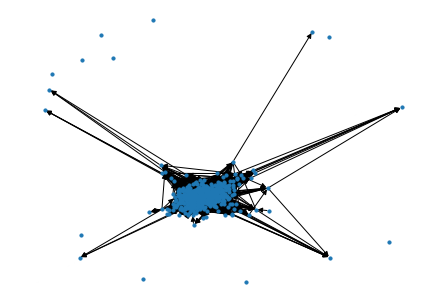

In [28]:
# Create Directed Graph based on mentions and retweets
def directed_graph(Data):
    # regex for mentions/ retweets
    regex_mentions_retweets = "\s([@][\w_-]+)"

    G = nx.DiGraph()

    for i in range(len(Data)):
        name = Data["TwitterUsernames"][i]
        G.add_node(name, Party=Data["Party"][i], Tweets=Data["Tweets"][i])  # new entry of representative in the graph
        usernames_before = re.findall(regex_mentions_retweets, Data["Tweets"][i])

        for username in usernames_before:
            username = username.strip().split('@')[1]

            if (username in Data["TwitterUsernames"].values) and (username != name):  # usernames / candidates
                G.add_edge(name, username)

    return G

G = directed_graph(Data)

# draw directed graph
plt.figure()
nx.draw(G, node_size=10)
plt.show()


In [29]:
# Create Giant Connected Component - GCC
def giant_connected_component(G):
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    GCC = G.subgraph(largest_cc)

    print("There are {} links in the GCC network.".format(GCC.number_of_edges()))
    print("There are {} nodes in the GCC network.".format(GCC.number_of_nodes()))

    between_representatives = 0

    for edge in GCC.edges:
        if GCC.nodes[edge[0]]['Party'] != GCC.nodes[edge[1]]['Party']:
            between_representatives += 1

    print(f'Number of links between the representatives/ senators: {between_representatives}')
    print(f'Percentage of links between the representatives/ senators: {round(between_representatives / GCC.number_of_edges() * 100, 1)} %')

    return GCC

GCC = giant_connected_component(G)

There are 4947 links in the GCC network.
There are 526 nodes in the GCC network.
Number of links between the representatives/ senators: 890
Percentage of links between the representatives/ senators: 18.0 %


As we can see the total number of links in our network is 4947 and the total number of nodes is 527 representatives/ senators. Also, there are 890 connections (18%) between the representatives/ senators.

In [32]:
def in_out_deg(G):
    in_deg = []
    for i in G.nodes:
        in_deg.append(G.in_degree(i))

    index_max_in = sorted(range(len(in_deg)), reverse=True, key=lambda k: in_deg[k])

    node_names = []
    for i in G.nodes:
        node_names.append(i)

    index_max_in = index_max_in[0:5]

    print('The 5 most connected in-degree representatives/ senators are:')

    for i in range(len(index_max_in)):
        index = index_max_in[i]
        print(node_names[index])

    out_deg = []
    for i in G.nodes:
        out_deg.append(G.out_degree(i))

    index_max_out = sorted(range(len(out_deg)), reverse=True, key=lambda k: out_deg[k])

    index_max_out = index_max_out[0:5]

    print('\nThe 5 most connected out-degree representatives/ senators are:')

    for i in range(len(index_max_out)):
        index = index_max_out[i]
        print(node_names[index])

    #return in_deg, out_deg

in_out_deg(GCC)

The 5 most connected in-degree representatives are:
SpeakerPelosi
GOPLeader
SteveScalise
KamalaHarris
SenSchumer

The 5 most connected out-degree representatives are:
SteveScalise
RepBradWenstrup
RepGuthrie
RepBonnie
RepRashida


Some of the most mentioned and retweeted representatives/ senators are *Nancy Pelosi*, *Kevin McCarthy*, *Steve Scalise*, *Kamala Harris* and *Chuck Schumer*. Also, the representatives/ senators that retweet or mention other congrees members mostly are: *Steve Scalise*, *Brad Wenstrup*, *S. Brett Guthrie*, *Bonnie Watson Coleman* and *Rashida Tlaib*.  

Let's take a look on the distribution of the in and out degree.

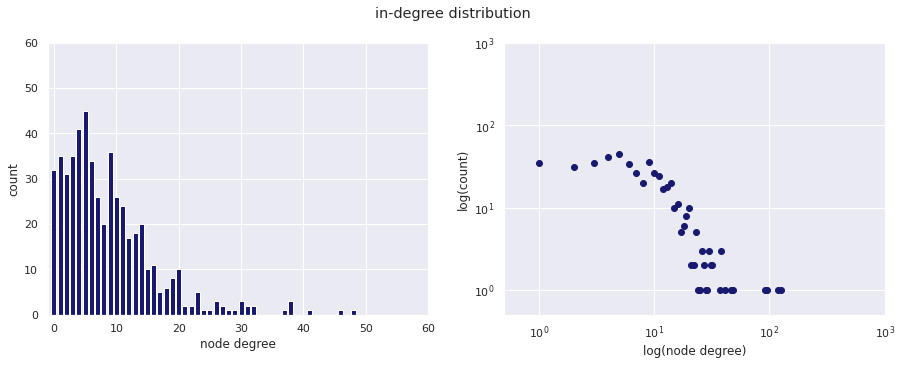

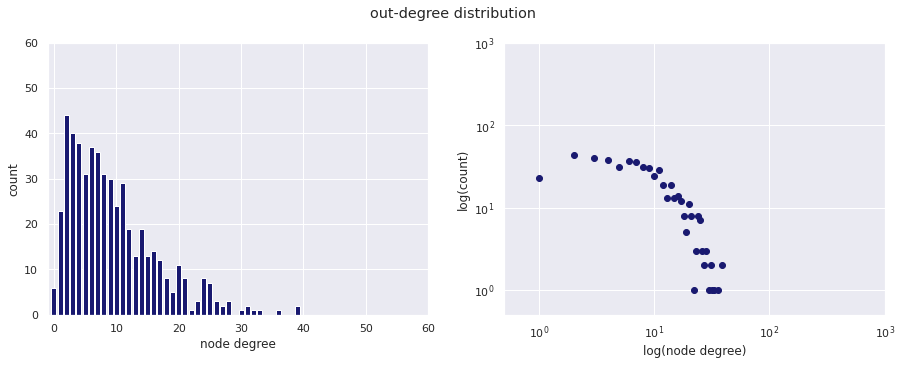

In [35]:
def distribution(G, mode):
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)

    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins=np.arange(dmin - 0.5, dmax + 1.5, 1))

    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
    fig.suptitle(mode + '-degree distribution')

    ax1.bar(np.arange(dmin, dmax + 1, 1), counts, color='midnightblue')
    ax1.set_xlim(-1, 60)
    ax1.set_ylim(0, 60)
    ax1.set_xlabel('node degree')
    ax1.set_ylabel('count')

    ax2.loglog(np.arange(dmin, dmax + 1, 1), counts, 'o', color='midnightblue')
    ax2.set_xlim(0.5, 10 ** 3)
    ax2.set_ylim(0.5, 10 ** 3)
    ax2.set_xlabel('log(node degree)')
    ax2.set_ylabel('log(count)')
    plt.show()

distribution(GCC, 'in')
distribution(GCC, 'out')

TODO: Comment on distribution

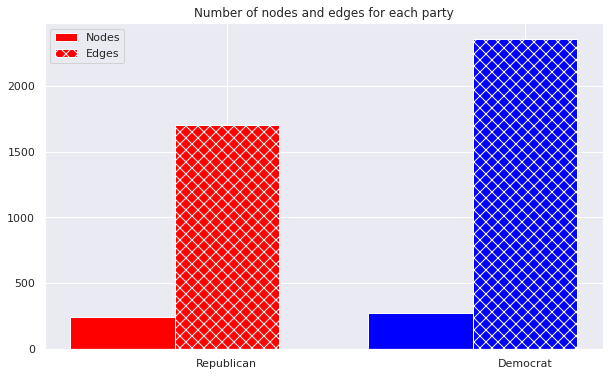

In [80]:
plt.rcParams["figure.figsize"] = [10, 6]

fig, ax = plt.subplots()

sizes_nodes = [len([x for x,y in GCC.nodes(data=True) if y['Party']=="Republican"]), len([x for x,y in GCC.nodes(data=True) if y['Party']=="Democrat"])]
sizes_edges = [len([edge for edge in GCC.edges if GCC.nodes[edge[0]]['Party'] == "Republican" and GCC.nodes[edge[1]]['Party'] == "Republican"]), len([edge for edge in GCC.edges if GCC.nodes[edge[0]]['Party'] == "Democrat" and GCC.nodes[edge[1]]['Party'] == "Democrat"])]

ind = np.arange(len(sizes_nodes))
width = 0.35
colors = ['red', 'blue']

rects1 = ax.bar(ind, sizes_nodes, width, color = colors)
rects2 = ax.bar(ind+width, sizes_edges, width, color = colors, hatch=r"//\\")

ax.legend((rects1[0], rects2[0]), ("Nodes", "Edges"))

ax.set_xticks(ind+width)
ax.set_xticklabels(sizes.keys())
plt.title("Number of nodes and edges for each party")
plt.show()

Based on the above figure we can see that even the number of representatives/ senators each party has is almost equally, Democrats connect, communicate and interact with each other much more. 

In [81]:
# create the undirected graph
GU = GCC.to_undirected()

100%|██████████| 4000/4000 [00:05<00:00, 671.08it/s]
BarnesHut Approximation  took  4.20  seconds
Repulsion forces  took  0.08  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.74  seconds
AdjustSpeedAndApplyForces step  took  0.43  seconds


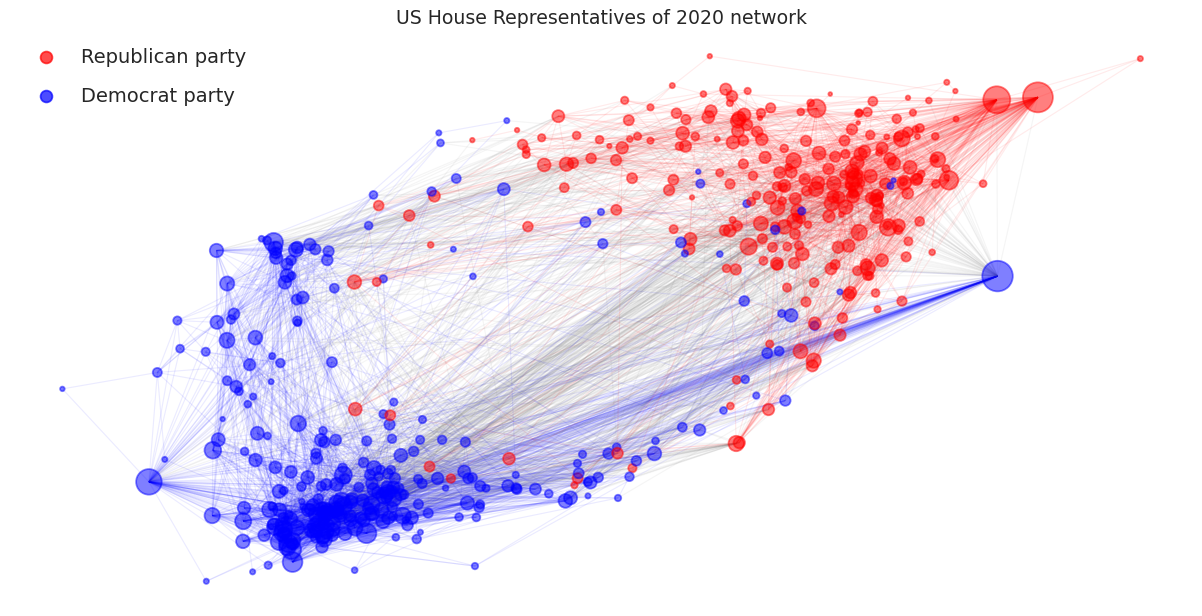

In [84]:
def forceatlas_graph(GU):
    # Color nodes according to party
    colors = []
    for n in list(GU.nodes(data="Party")):
        if 'Republican' in n:
            colors.append('red')
        else:
            colors.append('blue')

            # Scale node-size according to degree
    d = nx.degree(GU)
    sizes = [(d[node] + 1) * 5 for node in GU.nodes()]

    # Color edges according to between-party or not
    edge_colors = []
    for edge in GU.edges:
        if GU.nodes[edge[0]]['Party'] != GU.nodes[edge[1]]['Party']:
            edge_colors.append('grey')
        else:
            if GU.nodes[edge[0]]['Party'] == 'Republican':
                edge_colors.append('red')
            else:
                edge_colors.append('blue')

    # Specify the settings for the Force Atlas 2 algorithm
    forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=True,  # Dissuade hubs
        linLogMode=False,  # NOT IMPLEMENTED
        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=7.0,

        # Performance
        jitterTolerance=0.5,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=40,
        multiThreaded=False,  # NOT IMPLEMENTED

        # Tuning
        scalingRatio=0.5,
        strongGravityMode=False,
        gravity=0,

        # Log
        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=4000)

    plt.figure(num=None, figsize=(18, 9), dpi=85, facecolor='w', edgecolor='k')

    sns.set_style('whitegrid')
    sns.set_context('talk')

    # create legend
    plt.scatter([], [], c='red', alpha=0.7, s=100, label='Republican party')
    plt.scatter([], [], c='blue', alpha=0.7, s=100, label='Democrat party')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    nx.draw_networkx_nodes(GU, positions, node_size=sizes, node_color=colors, alpha=0.5)
    nx.draw_networkx_edges(GU, positions, edge_color=edge_colors, alpha=0.08)
    ax = plt.gca()
    ax.collections[0].set_linewidth(0.1)
    ax.set_title('US House Representatives of 2020 network', fontsize=16);
    plt.axis('off')
    plt.show()


forceatlas_graph(GU)

### 3. Tools, Theory and Analysis

### 5. Contribution 

* Electra Zarafeta - s202238:
* Idriss El Quassimi - s:
* Asterios Nastas - s:

#### References: 
\[1] https://triagecancer.org/congressional-social-media